[IPython Notebook](meshes.ipynb) |  [Python Script](meshes.py)

Accessing and Plotting Meshes
============================

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new Bundle.  See [Building a System](building_a_system.html) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='INFO')

b = phoebe.default_binary()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


/usr/local/lib/python2.7/dist-packages/astropy/units/quantity.py:732: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__eq__(other)


The Protomesh
---------------------

The 'Protomesh' is the mesh of each star in its own reference frame at periastron.  The coordinates are defined such that the x-axis points towards the other component in the parent orbit.

To build the protomesh, set 'store_mesh' to be True, either in the compute options or directly as a keyword argument when calling run_compute.

In [3]:
b.run_compute(store_mesh=True)

<ParameterSet: 32 parameters | datasets: protomesh, automesh>

You'll see that the resulting model has a single dataset kind ('MESH'), but exists with two different dataset tags ('protomesh' and 'automesh').  Neither of these were datasets that we attached to the dataset context - rather they were created in the model context because we passed store_mesh=True

In [4]:
print b['model'].kinds

['MESH']


In [5]:
print b['model'].datasets

['protomesh', 'automesh']


For now, we'll just look at the parameters in the 'protomesh' dataset

In [6]:
b.filter(dataset='protomesh', context='model')

<ParameterSet: 30 parameters | components: primary, secondary>

In [7]:
b.filter(dataset='protomesh', context='model', component='primary')

<ParameterSet: 15 parameters | qualifiers: teff, ny, tareas, vertices, nx, logg, nz, r, cosbeta, normals, y, x, z, visible_centroids, areas>

In [8]:
b.get_value(dataset='protomesh', context='model', component='primary', qualifier='teff')

array([ 9990.44010172,  9990.4559553 ,  9990.44010172, ...,  9998.86221175,
        9999.18998802,  9998.96270752])

In [9]:
# NOTE: 'teff' is currently removed from the protomesh - may come back soon
#axs, artists = b.filter(dataset='protomesh', context='model', component='secondary').plot(facecolor='teff', edgecolor=None)

In [10]:
#axs, artists = b.filter(dataset='protomesh', context='model', component='secondary').plot(facecolor='teff', edgecolor=None)

The 'Automesh'
----------------------

'Automesh' is an automatically-created dataset in the returned model which stores the mesh at every time-point at which it was required to be built by other existing datasets.

Again, these will only be stored in the returned model if store_mesh=True is passed during run_compute or is True in the passed compute options.

In [11]:
b.add_dataset('LC', time=[0,1,2], dataset='lc01')

<ParameterSet: 14 parameters | contexts: compute, dataset>

In [12]:
b.run_compute(store_mesh=True)

<ParameterSet: 214 parameters | kinds: MESH, LC>

Our model now has dataset kinds for both the MESH and LC and has dataset tags for our newly-created 'lc01' dataset as well as the 'protomesh' and 'automesh' datasets in the model created only because store_mesh=True.

In [13]:
print b['model'].kinds

['MESH', 'LC']


In [14]:
print b['model'].datasets

['lc01', 'protomesh', 'automesh']


This time let's look at the parameters in the 'automesh' dataset of the model.

In [15]:
b.filter(dataset='automesh', context='model')

<ParameterSet: 146 parameters | components: primary, secondary>

In [16]:
b.filter(dataset='automesh', context='model', component='primary')

<ParameterSet: 73 parameters | qualifiers: teff, pot, logg, vx, vy, vz, nx, ny, nz, time, r_proj, volume, rpole, visibility, areas, tareas, vertices, mu, r, cosbeta, normals, y, x, z, visible_centroids>

As you can see, the intensities are not available here - their dataset tags match the dataset of the light curve.  Instead let's access the mesh by method:

In [17]:
b.filter(method='MESH', context='model', component='primary')

<ParameterSet: 106 parameters | datasets: lc01, protomesh, automesh>

In [18]:
b.filter(dataset='lc01', kind='mesh', context='model', component='primary')

<ParameterSet: 18 parameters | qualifiers: intens_norm_abs, ampl_boost, intens_norm_rel, intens_proj_rel, pblum, intens_proj_abs>

To plot the intensities as color on the mesh, we can just plot the mesh and then reference the correct column by using twig access:

/home/kyle/.local/lib/python2.7/site-packages/phoebe/frontend/plotting.py:242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pckwargs['edgecolors'] in ['none', 'None', None] and pckwargs['facecolors'] not in ['none', 'None', None]:
/home/kyle/.local/lib/python2.7/site-packages/phoebe/frontend/plotting.py:242: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pckwargs['edgecolors'] in ['none', 'None', None] and pckwargs['facecolors'] not in ['none', 'None', None]:
/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


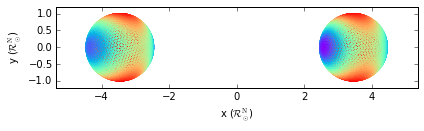

In [19]:
axs, artists = b.filter(kind='MESH', context='model', time=1.0).plot(facecolor='intens_proj_rel@lc01', edgecolor='teff')

The 'Mesh' Dataset
----------------------

If you want to force the plot itself to build at specific times but not have any observables (necessarily) computed or filled at those times, you can create a MESH dataset.

Let's create a mesh dataset that fills in the missing times from our LC dataset.

In [20]:
b.get_value('time@lc01@dataset')

array([ 0.,  1.,  2.])

In [21]:
b.add_dataset('MESH', time=[0.5, 1.5], dataset='mesh01')

<ParameterSet: 2 parameters | contexts: compute, dataset>

Now let's run_compute with store_mesh set to False

In [22]:
b.run_compute(store_mesh=False)

<ParameterSet: 124 parameters | kinds: MESH, LC>

As expected, the resulting model has dataset kinds for both MESH and LC, as well as datasets for 'mesh01' and 'lc01' - but the 'automesh' and 'protomesh' entries are no longer created (since store_mesh=False).

In [23]:
print b['model'].kinds

['MESH', 'LC']


In [24]:
print b['model'].datasets

['mesh01', 'lc01']


The meshes are only stored at the times of the mesh dataset - not at the times of the lc dataset.

In [25]:
b.filter(kind='MESH', context='model').times

['1.5', '0.5']

Since there was no lc requested at these times, the intensity columns will be empty.

In [26]:
b.get_value(kind='MESH', context='model', dataset='lc01', time=0.5, qualifier='intens_proj_rel', component='primary')

array([], dtype=float64)

But we can still plot any of the dataset-independent quantities

In [27]:
b.filter(dataset='mesh01', kind='MESH', context='model', component='primary', time=0.5)

<ParameterSet: 24 parameters | qualifiers: teff, pot, logg, vx, vy, vz, nx, ny, nz, r_proj, volume, rpole, visibility, areas, tareas, vertices, mu, r, cosbeta, normals, y, x, z, visible_centroids>

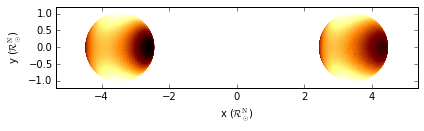

In [28]:
axs, artists = b.filter(dataset='mesh01', kind='MESH', context='model', time=0.5).plot(facecolor='teff', edgecolor=None)

If you want the meshes stored at both the times in the 'mesh' dataset and all /other/ datasets, simply set store_mesh to True.

In [29]:
b.run_compute(store_mesh=True)

<ParameterSet: 336 parameters | kinds: MESH, LC>

In [30]:
b.filter(kind='MESH', context='model').times

['1.5', '0.5', '2.0', '1.0', '0.0']